In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dill
import warnings
warnings.simplefilter("ignore", FutureWarning)  # diffrax tree_util
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.dirname(os.getcwd())))

# load predictions from dilled dictionary
db_predictions_path = "data/predictions.dill"
with open(db_predictions_path, 'rb') as f:
  datadict = dill.load(f)
# dict to DataFrame
tab = []
columns = ['model', 'driver', 'train level', 'test level', 'train ierror',
           'train verror', 'ierror', 'verror', 'i_psd', 'v_psd', 'ipred_psd',
           'vpred_psd', 'ei_psd', 'ev_psd']
for k, v in datadict.items():
  tab.append(list(k) + list(v))
del datadict
df = pd.DataFrame(tab, columns=columns)
del tab

# compute total error
df['total error'] = np.sqrt((df['ierror']**2 + df['verror']**2)/2)
df['train total error'] = np.sqrt((df['train ierror']**2 + df['train verror']**2)/2)

# filter out models that we leave out of paper
df.drop((df[df.model == 'PolyNonLinL2R2Cun4']).index, inplace=True)

print_names = {
  'LinearL2R2SLS': 'linear SLS+$L_2R_2$',
  'LinearL2R2': 'linear $L_2R_2$',
  'LinearSLS': 'linear SLS',
  'Simplest': 'linear',
  'PolyNonLinL2R2GenCunLi4': 'full w/o SLS',
  'PolyNonLinSLSL2R2GenCunLi4': 'full',
  'PolyNonLinSLSGenCunLi4': 'full w/o $L_2R_2$',
  'PolyNonLinSLSL2R2CunLi4': 'full reluctance as \cite{klippelTutorialLoudspeakerNonlinearities2006}',
  'PolyNonLinSLSL2R2GenCun4': 'full w/o $L(i)$',
  'PolyNonLinSLSL2R2Li4': 'full w/o reluctance',
  'PolyNonLinSLSL2R2GenCunLi7': 'full with $d=7$',
  'PolyNonLinSLSL2R2GenCunLi6': 'full with $d=6$',
  'PolyNonLinSLSL2R2GenCunLi5': 'full with $d=5$',
  'PolyNonLinSLSL2R2GenCunLi4': 'full with $d=4$',
  'PolyNonLinSLSL2R2GenCunLi3': 'full with $d=3$',
  'PolyNonLinSLSL2R2GenCunLi2': 'full with $d=2$',
  'PolyNonLinSLSL2R2GenCunLi1': 'full with $d=1$',
  'PolyNonLinSLSL2R2GenCunLi0': 'full with $d=0$',
}

Filter all results that are much worse than "Simplest". There must have been some convergence issue for those.

In [2]:
df_all = df.copy()
df_simplest = df[df.model == 'Simplest']
# compare each row to results of simplest
for index, row in df.iterrows():
  simplest_row = df_simplest[(df_simplest.driver == row.driver) & 
                             (df_simplest['train level'] == row['train level']) &
                             (df_simplest['test level'] == row['test level'])]
  assert(len(simplest_row)) == 1
  simplest_row = simplest_row.iloc[0]
  # drop if error much larger than error from simplest model or if nan
  if (row['total error'] > 1.5 * simplest_row['total error']) or np.isnan(row['total error']):
    df.drop(index, inplace=True)

Overview all models

In [3]:
df.groupby('model').mean().sort_values('train total error')

,train level,test level,train ierror,train verror,ierror,verror,total error,train total error
model,,,,,,,,
PolyNonLinSLSL2R2GenCunLi2,0.495787,0.443820,0.046806,0.060354,0.063879,0.087239,0.077881,0.055301
PolyNonLinSLSL2R2GenCunLi3,0.540584,0.389610,0.047761,0.060421,0.061885,0.086073,0.076450,0.055741
PolyNonLinSLSL2R2GenCunLi4_Heun,0.515244,0.411585,0.048982,0.060235,0.072617,0.095456,0.086074,0.055889
PolyNonLinSLSL2R2GenCunLi6,0.571429,0.371429,0.047943,0.060613,0.062874,0.086372,0.076958,0.056013
PolyNonLinSLSL2R2GenCunLi4_Ralston,0.518519,0.404321,0.051596,0.059526,0.074513,0.094686,0.086439,0.056565
PolyNonLinSLSL2R2GenCunLi5,0.538462,0.384615,0.049097,0.061086,0.062397,0.084225,0.075390,0.056576
PolyNonLinSLSL2R2GenCunLi4_Dopri5,0.516768,0.402439,0.049736,0.061352,0.070244,0.094083,0.084236,0.056911
PolyNonLinSLSL2R2GenCunLi4,0.516768,0.402439,0.049736,0.061352,0.070244,0.094083,0.084236,0.056911
PolyNonLinSLSL2R2CunLi4,0.516768,0.402439,0.052203,0.061074,0.072284,0.093737,0.084729,0.057529


In [4]:
df.groupby('model').mean().sort_values('total error')

,train level,test level,train ierror,train verror,ierror,verror,total error,train total error
model,,,,,,,,
PolyNonLinSLSL2R2GenCunLi5,0.538462,0.384615,0.049097,0.061086,0.062397,0.084225,0.075390,0.056576
PolyNonLinSLSL2R2GenCunLi3,0.540584,0.389610,0.047761,0.060421,0.061885,0.086073,0.076450,0.055741
PolyNonLinSLSL2R2GenCunLi7,0.590385,0.350000,0.053666,0.060725,0.066334,0.084035,0.076746,0.058213
PolyNonLinSLSL2R2GenCunLi6,0.571429,0.371429,0.047943,0.060613,0.062874,0.086372,0.076958,0.056013
PolyNonLinSLSL2R2GenCunLi2,0.495787,0.443820,0.046806,0.060354,0.063879,0.087239,0.077881,0.055301
PolyNonLinSLSL2R2GenCunLi1,0.478495,0.451613,0.056347,0.077042,0.067218,0.094968,0.083626,0.068474
PolyNonLinSLSL2R2GenCunLi4_Dopri5,0.516768,0.402439,0.049736,0.061352,0.070244,0.094083,0.084236,0.056911
PolyNonLinSLSL2R2GenCunLi4,0.516768,0.402439,0.049736,0.061352,0.070244,0.094083,0.084236,0.056911
PolyNonLinSLSL2R2CunLi4,0.516768,0.402439,0.052203,0.061074,0.072284,0.093737,0.084729,0.057529


Some statistics of the dataset:

In [5]:
print('Total number of datapoints:', len(df_all))
print('Number of models tested:', len(df_all.model.unique()))
print('Number of drivers tested:', len(df_all.driver.unique()))
print('Number of rms levels:', len(df_all['train level'].unique()))
print('Number of failed convergence on test data:', (len(df_all) - len(df)))
print('% of failed convergence on test data:', (len(df_all) - len(df))/len(df_all)*100)

Total number of datapoints: 2304
Number of models tested: 24
Number of drivers tested: 6
Number of rms levels: 4
Number of failed convergence on test data: 311
% of failed convergence on test data: 13.49826388888889


selectors

In [6]:
select_poly = df["model"].str.fullmatch(r'^PolyNonLinSLSL2R2GenCunLi[0-9]$')
select_odesolver =  df["model"].str.fullmatch(r'^PolyNonLinSLSL2R2GenCunLi4_.*$')
select_highrms_train = df["train level"] == 1.0
select_highrms_test = df["test level"] == 1.0
select_highrms_both = select_highrms_train & select_highrms_test
select_lowrms_train = df["train level"] == 0.125
select_lowrms_test = df["test level"] == 0.125
select_lowrms_both = select_lowrms_train & select_lowrms_test
full = df["model"] == "PolyNonLinSLSL2R2GenCunLi4"

## Compare polynomial orders


At large amplitude: 2nd or 3rd oder as good as rest.

In [7]:
# ordered by train error
df[select_poly & select_highrms_both].groupby('model').mean().sort_values('train total error')

,train level,test level,train ierror,train verror,ierror,verror,total error,train total error
model,,,,,,,,
PolyNonLinSLSL2R2GenCunLi6,1.0,1.0,0.057761,0.068589,0.060416,0.062188,0.062933,0.065132
PolyNonLinSLSL2R2GenCunLi5,1.0,1.0,0.057765,0.068646,0.060423,0.062147,0.062919,0.065168
PolyNonLinSLSL2R2GenCunLi4,1.0,1.0,0.057771,0.068682,0.060436,0.062210,0.062964,0.065195
PolyNonLinSLSL2R2GenCunLi3,1.0,1.0,0.058370,0.069797,0.061309,0.063782,0.064075,0.065978
PolyNonLinSLSL2R2GenCunLi2,1.0,1.0,0.058717,0.070538,0.061529,0.064356,0.064497,0.066512
PolyNonLinSLSL2R2GenCunLi7,1.0,1.0,0.066072,0.067753,0.068689,0.061534,0.065588,0.067724
PolyNonLinSLSL2R2GenCunLi1,1.0,1.0,0.085097,0.115719,0.087239,0.114302,0.103148,0.102932
PolyNonLinSLSL2R2GenCunLi0,1.0,1.0,0.091508,0.119803,0.093592,0.118805,0.108539,0.108121


In [8]:
# ordered by test error
df[select_poly & select_highrms_both].groupby('model').mean().sort_values('total error')

,train level,test level,train ierror,train verror,ierror,verror,total error,train total error
model,,,,,,,,
PolyNonLinSLSL2R2GenCunLi5,1.0,1.0,0.057765,0.068646,0.060423,0.062147,0.062919,0.065168
PolyNonLinSLSL2R2GenCunLi6,1.0,1.0,0.057761,0.068589,0.060416,0.062188,0.062933,0.065132
PolyNonLinSLSL2R2GenCunLi4,1.0,1.0,0.057771,0.068682,0.060436,0.062210,0.062964,0.065195
PolyNonLinSLSL2R2GenCunLi3,1.0,1.0,0.058370,0.069797,0.061309,0.063782,0.064075,0.065978
PolyNonLinSLSL2R2GenCunLi2,1.0,1.0,0.058717,0.070538,0.061529,0.064356,0.064497,0.066512
PolyNonLinSLSL2R2GenCunLi7,1.0,1.0,0.066072,0.067753,0.068689,0.061534,0.065588,0.067724
PolyNonLinSLSL2R2GenCunLi1,1.0,1.0,0.085097,0.115719,0.087239,0.114302,0.103148,0.102932
PolyNonLinSLSL2R2GenCunLi0,1.0,1.0,0.091508,0.119803,0.093592,0.118805,0.108539,0.108121


for print

In [9]:
from functools import reduce

mean_df = (df[select_poly & select_highrms_both]
.groupby('model')
.mean()
.drop(columns=['train level', 'test level'])[['train ierror', 'train verror', 'train total error', 'ierror', 'verror', 'total error']]
)
std_df = (df[select_poly & select_highrms_both]
.groupby('model')
.std()
.drop(columns=['train level', 'test level'])[['train ierror', 'train verror', 'train total error', 'ierror', 'verror', 'total error']]
.rename(columns={k:k+" std" for k in mean_df.columns})
)

mean_std = (mean_df
.join(std_df)
.applymap(lambda x: x*100)
.sort_values('total error')[list(reduce(lambda x, y: x+y, zip(mean_df.columns, std_df.columns)))]
)

with pd.option_context('display.float_format', '{:,.1f}'.format):
    out = mean_std.to_latex()
    for key, value in print_names.items():
        # Replace key character with value character in string
        out = out.replace(key, value)
    import re
    # replace header
    p = re.compile(r'&(.+?)&.+?std')
    out = p.sub(r'\1', out)
    # replace "mean & std" with "mean \pm std"
    p = re.compile(r' +([0-9]+\.[0-9])+ & +([0-9]+\.[0-9])+ ')
    out = p.sub(r' $\1\\pm \2$ ', out)
    print(out)

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{}   train ierror    train verror    train total error    ierror    verror    total error  \\
model                      &               &                   &               &                   &                    &                        &         &             &         &             &              &                  \\
\midrule
full with $d=5$ & $5.8\pm 2.3$ & $6.9\pm 2.7$ & $6.5\pm 1.9$ & $6.0\pm 2.7$ & $6.2\pm 3.1$ & $6.3\pm 2.5$ \\
full with $d=6$ & $5.8\pm 2.3$ & $6.9\pm 2.6$ & $6.5\pm 1.9$ & $6.0\pm 2.7$ & $6.2\pm 3.1$ & $6.3\pm 2.5$ \\
full with $d=4$ & $5.8\pm 2.3$ & $6.9\pm 2.7$ & $6.5\pm 1.9$ & $6.0\pm 2.7$ & $6.2\pm 3.1$ & $6.3\pm 2.5$ \\
full with $d=3$ & $5.8\pm 2.3$ & $7.0\pm 2.6$ & $6.6\pm 1.9$ & $6.1\pm 2.7$ & $6.4\pm 3.1$ & $6.4\pm 2.5$ \\
full with $d=2$ & $5.9\pm 2.3$ & $7.1\pm 2.6$ & $6.7\pm 1.9$ & $6.2\pm 2.7$ & $6.4\pm 3.1$ & $6.4\pm 2.5$ \\
full with $d=7$ & $6.6\pm 2.5$ & $6.8\pm 2.5$ & $6.8\pm 2.2$ & $6.9\pm 2.8$ & $6.2

At low amplitude: all orders comparable performance.

In [10]:
df[select_poly & select_lowrms_both].groupby('model').mean().sort_values('train total error')

,train level,test level,train ierror,train verror,ierror,verror,total error,train total error
model,,,,,,,,
PolyNonLinSLSL2R2GenCunLi7,0.125,0.125,0.041033,0.057738,0.041458,0.058931,0.052125,0.051268
PolyNonLinSLSL2R2GenCunLi6,0.125,0.125,0.041040,0.057736,0.041451,0.058913,0.052112,0.051268
PolyNonLinSLSL2R2GenCunLi5,0.125,0.125,0.041037,0.057742,0.041427,0.058858,0.052076,0.051272
PolyNonLinSLSL2R2GenCunLi3,0.125,0.125,0.041093,0.057748,0.041490,0.058860,0.052091,0.051285
PolyNonLinSLSL2R2GenCunLi1,0.125,0.125,0.041207,0.058016,0.041623,0.059113,0.052282,0.051475
PolyNonLinSLSL2R2GenCunLi2,0.125,0.125,0.043857,0.057336,0.044219,0.058466,0.052567,0.051768
PolyNonLinSLSL2R2GenCunLi0,0.125,0.125,0.044262,0.059694,0.044679,0.060739,0.053994,0.053207
PolyNonLinSLSL2R2GenCunLi4,0.125,0.125,0.048876,0.056810,0.049253,0.058003,0.054174,0.053359


In [11]:
df[select_poly & select_lowrms_both].groupby('model').mean().sort_values('total error')

,train level,test level,train ierror,train verror,ierror,verror,total error,train total error
model,,,,,,,,
PolyNonLinSLSL2R2GenCunLi5,0.125,0.125,0.041037,0.057742,0.041427,0.058858,0.052076,0.051272
PolyNonLinSLSL2R2GenCunLi3,0.125,0.125,0.041093,0.057748,0.041490,0.058860,0.052091,0.051285
PolyNonLinSLSL2R2GenCunLi6,0.125,0.125,0.041040,0.057736,0.041451,0.058913,0.052112,0.051268
PolyNonLinSLSL2R2GenCunLi7,0.125,0.125,0.041033,0.057738,0.041458,0.058931,0.052125,0.051268
PolyNonLinSLSL2R2GenCunLi1,0.125,0.125,0.041207,0.058016,0.041623,0.059113,0.052282,0.051475
PolyNonLinSLSL2R2GenCunLi2,0.125,0.125,0.043857,0.057336,0.044219,0.058466,0.052567,0.051768
PolyNonLinSLSL2R2GenCunLi0,0.125,0.125,0.044262,0.059694,0.044679,0.060739,0.053994,0.053207
PolyNonLinSLSL2R2GenCunLi4,0.125,0.125,0.048876,0.056810,0.049253,0.058003,0.054174,0.053359


Conclusion: do not need very large order. Third or second-order seems sufficient.

## Compare Linear and nonlinear models

At high level

In [12]:
selector = ((~select_poly & ~select_odesolver) | full) & select_highrms_both
df[selector].groupby('model').mean().sort_values('total error')

,train level,test level,train ierror,train verror,ierror,verror,total error,train total error
model,,,,,,,,
PolyNonLinSLSL2R2GenCunLi4,1.0,1.0,0.057771,0.068682,0.060436,0.062210,0.062964,0.065195
PolyNonLinSLSL2R2GenCun4,1.0,1.0,0.058726,0.068691,0.061598,0.062219,0.063602,0.065709
PolyNonLinSLSL2R2CunLi4,1.0,1.0,0.062511,0.068111,0.065086,0.061691,0.064150,0.066387
PolyNonLinSLSL2R2Li4,1.0,1.0,0.066159,0.067745,0.068710,0.061240,0.065497,0.067776
PolyNonLinL2R2GenCunLi4,1.0,1.0,0.058797,0.074880,0.061458,0.068889,0.066555,0.068731
LinearL2R2SLS,1.0,1.0,0.097458,0.119232,0.099901,0.118253,0.110774,0.110252
LinearL2R2,1.0,1.0,0.093269,0.123787,0.095572,0.122652,0.111456,0.111001
PolyNonLinSLSGenCunLi4,1.0,1.0,0.156833,0.069974,0.160177,0.061745,0.121778,0.121966
LinearSLS,1.0,1.0,0.169065,0.125943,0.171911,0.124795,0.152139,0.151316


For print:

In [13]:
mean_df = (df[selector]
.groupby('model')
.mean()
.drop(columns=['train level', 'test level'])[['train ierror', 'train verror', 'train total error', 'ierror', 'verror', 'total error']]
)
std_df = (df[selector]
.groupby('model')
.std()
.drop(columns=['train level', 'test level'])[['train ierror', 'train verror', 'train total error', 'ierror', 'verror', 'total error']]
.rename(columns={k:k+" std" for k in mean_df.columns})
)

mean_std = (mean_df
.join(std_df)
.applymap(lambda x: x*100)
.sort_values('total error')[list(reduce(lambda x, y: x+y, zip(mean_df.columns, std_df.columns)))]
)

with pd.option_context('display.float_format', '{:,.1f}'.format):
    out = mean_std.to_latex()

    # replace model names
    for key, value in print_names.items():
        out = out.replace(key, value)

    import re
    # replace two columns with one plus minus column
    p = re.compile(r'&(.+?)&.+?std')
    out = p.sub(r'\1', out)
    # replace "mean & std" with "mean \pm std"
    p = re.compile(r' +([0-9]+\.[0-9])+ & +([0-9]+\.[0-9])+ ')
    out = p.sub(r' $\1\\pm \2$ ', out)
    print(out)

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{}   train ierror    train verror    train total error    ierror    verror    total error  \\
model                      &               &                   &               &                   &                    &                        &         &             &         &             &              &                  \\
\midrule
full with $d=4$ & $5.8\pm 2.3$ & $6.9\pm 2.7$ & $6.5\pm 1.9$ & $6.0\pm 2.7$ & $6.2\pm 3.1$ & $6.3\pm 2.5$ \\
full w/o $L(i)$   & $5.9\pm 2.5$ & $6.9\pm 2.6$ & $6.6\pm 2.0$ & $6.2\pm 2.9$ & $6.2\pm 3.1$ & $6.4\pm 2.6$ \\
full reluctance as \cite{klippelTutorialLoudspeakerNonlinearities2006}    & $6.3\pm 2.2$ & $6.8\pm 2.5$ & $6.6\pm 2.0$ & $6.5\pm 2.6$ & $6.2\pm 3.0$ & $6.4\pm 2.6$ \\
full w/o reluctance       & $6.6\pm 2.5$ & $6.8\pm 2.5$ & $6.8\pm 2.3$ & $6.9\pm 2.8$ & $6.1\pm 3.0$ & $6.5\pm 2.8$ \\
full w/o SLS    & $5.9\pm 2.4$ & $7.5\pm 2.2$ & $6.9\pm 1.7$ & $6.1\pm 2.7$ & $6.9\pm 2.7$ & $6.7\pm 2.3$ \\
linear SLS+$

At low input level

In [14]:
df[((~select_poly & ~select_odesolver) | full) & select_lowrms_both].groupby('model').mean().sort_values('train total error')
#df_tmp.drop(columns=['train level', 'test level', 'train ierror', 'train verror', 'train total error'])

,train level,test level,train ierror,train verror,ierror,verror,total error,train total error
model,,,,,,,,
PolyNonLinSLSL2R2Li4,0.125,0.125,0.048310,0.056887,0.048668,0.058080,0.053970,0.053160
PolyNonLinSLSL2R2CunLi4,0.125,0.125,0.048437,0.056883,0.048803,0.058076,0.054024,0.053211
PolyNonLinSLSL2R2GenCunLi4,0.125,0.125,0.048876,0.056810,0.049253,0.058003,0.054174,0.053359
LinearL2R2SLS,0.125,0.125,0.049896,0.059167,0.050302,0.060266,0.055789,0.055001
PolyNonLinSLSL2R2GenCun4,0.125,0.125,0.056806,0.059439,0.057359,0.060429,0.059310,0.058531
PolyNonLinL2R2GenCunLi4,0.125,0.125,0.044896,0.073060,0.045535,0.073571,0.061812,0.061226
LinearL2R2,0.125,0.125,0.045834,0.074663,0.046447,0.075076,0.063040,0.062527
PolyNonLinSLSGenCunLi4,0.125,0.125,0.155038,0.056935,0.156884,0.057135,0.118646,0.117341
LinearSLS,0.125,0.125,0.151782,0.070249,0.153548,0.070578,0.121264,0.119977


Compare error over level

In [15]:
selector = ((~select_poly & ~select_odesolver) | full) & select_highrms_train
pd.crosstab(
  df[selector]['model'],
  df[selector]['test level'],
  values=df[selector]['total error'],
  aggfunc='mean',
  margins=False, ).sort_values(1.0)

test level,0.125,0.250,0.500,1.000
model,,,,
PolyNonLinSLSL2R2GenCunLi4,0.116285,0.087333,0.080130,0.062964
PolyNonLinSLSL2R2GenCun4,0.116849,0.087798,0.080314,0.063602
PolyNonLinSLSL2R2CunLi4,0.116789,0.088115,0.081164,0.064150
PolyNonLinSLSL2R2Li4,0.118090,0.089520,0.082572,0.065497
PolyNonLinL2R2GenCunLi4,0.120118,0.091307,0.084258,0.066555
LinearL2R2SLS,0.098617,0.088989,0.096763,0.110774
LinearL2R2,0.100801,0.091169,0.098809,0.111456
PolyNonLinSLSGenCunLi4,0.163918,0.140922,0.137843,0.121778
LinearSLS,0.147231,0.141466,0.148210,0.152139


In [16]:
selector = ((~select_poly & ~select_odesolver) | full) & select_lowrms_train
pd.crosstab(
  df[selector]['model'],
  df[selector]['test level'],
  values=df[selector]['total error'],
  aggfunc='mean',
  margins=False, )

test level,0.125,0.250,0.500,1.000
model,,,,
LinearL2R2,0.063040,0.074417,0.108154,0.135962
LinearL2R2SLS,0.055789,0.070008,0.105745,0.135512
LinearSLS,0.121264,0.127349,0.150983,0.170066
PolyNonLinL2R2GenCunLi4,0.061812,0.076855,0.175027,NaN
PolyNonLinSLSGenCunLi4,0.118646,0.123850,0.202782,NaN
PolyNonLinSLSL2R2CunLi4,0.054024,0.069310,0.203867,NaN
PolyNonLinSLSL2R2GenCun4,0.059310,0.074605,0.205445,NaN
PolyNonLinSLSL2R2GenCunLi4,0.054174,0.069415,0.203698,NaN
PolyNonLinSLSL2R2Li4,0.053970,0.069024,0.201563,NaN


for print

In [17]:
# high rms
selector = ((~select_poly & ~select_odesolver) | full) & select_highrms_train
mean_highrms = pd.crosstab(
  df[selector]['model'],
  df[selector]['test level'],
  values=df[selector]['total error'],
  aggfunc='mean',
  margins=False, ).sort_values(1.0)

std_highrms = pd.crosstab(
  df[selector]['model'],
  df[selector]['test level'],
  values=df[selector]['total error'],
  aggfunc='std',
  margins=False, ).rename(columns={k:str(k)+" std" for k in mean_highrms.columns})

mean_std_highrms = (mean_highrms
.join(std_highrms)
.applymap(lambda x: x*100)
.sort_values(1.0)
)[list(reduce(lambda x, y: x+y, zip(mean_highrms.columns, std_highrms.columns)))]

# low rms
selector = ((~select_poly & ~select_odesolver) | full) & select_lowrms_train
mean_lowrms = pd.crosstab(
  df[selector]['model'],
  df[selector]['test level'],
  values=df[selector]['total error'],
  aggfunc='mean',
  margins=False, ).sort_values(1.0)

std_lowrms = pd.crosstab(
  df[selector]['model'],
  df[selector]['test level'],
  values=df[selector]['total error'],
  aggfunc='std',
  margins=False, ).rename(columns={k:str(k)+" std" for k in mean_lowrms.columns})

mean_std_lowrms = (mean_lowrms
.join(std_lowrms)
.applymap(lambda x: x*100)
.sort_values(1.0)
)[list(reduce(lambda x, y: x+y, zip(mean_lowrms.columns, std_lowrms.columns)))]

mean_std_lowrms = mean_std_lowrms.rename(columns={k:str(k)+" lowtrain" for k in mean_std_lowrms.columns})

# combine low and high rms
mean_std_all = mean_std_lowrms.join(mean_std_highrms)
mean_std_all = mean_std_all.drop(columns=[
  '0.25 lowtrain',
	'0.25 std lowtrain',
  '0.5 lowtrain',
	'0.5 std lowtrain',
  '1.0 lowtrain',
	'1.0 std lowtrain']).sort_values(1.0)

with pd.option_context('display.float_format', '{:,.1f}'.format):
    out = mean_std_all.to_latex()

    # replace model names
    for key, value in print_names.items():
        out = out.replace(key, value)

    import re
    # replace two columns with one plus minus column
    p = re.compile(r'&(.+?)&.+?std')
    out = p.sub(r'\1', out)
    # replace "mean & std" with "mean \pm std"
    p = re.compile(r' +([0-9]+\.[0-9])+ & +([0-9]+\.[0-9])+ ')
    out = p.sub(r' $\1\\pm \2$ ', out)
    print(out)

\begin{tabular}{lrrrrrrrrrr}
\toprule
test level   0.125 lowtrain  lowtrain   0.125    0.25    0.5    1.0  \\
model                      &                 &                     &        &            &       &           &      &          &      &          \\
\midrule
full with $d=4$ & $5.4\pm 2.7$ & $11.6\pm 3.6$ & $8.7\pm 2.1$ & $8.0\pm 3.1$ & $6.3\pm 2.5$ \\
full w/o $L(i)$   & $5.9\pm 3.8$ & $11.7\pm 3.6$ & $8.8\pm 2.0$ & $8.0\pm 3.1$ & $6.4\pm 2.6$ \\
full reluctance as \cite{klippelTutorialLoudspeakerNonlinearities2006}    & $5.4\pm 2.7$ & $11.7\pm 3.6$ & $8.8\pm 2.1$ & $8.1\pm 3.2$ & $6.4\pm 2.6$ \\
full w/o reluctance       & $5.4\pm 2.7$ & $11.8\pm 3.6$ & $9.0\pm 2.2$ & $8.3\pm 3.2$ & $6.5\pm 2.8$ \\
full w/o SLS    & $6.2\pm 1.9$ & $12.0\pm 3.5$ & $9.1\pm 1.9$ & $8.4\pm 3.0$ & $6.7\pm 2.3$ \\
linear SLS+$L_2R_2$              & $5.6\pm 2.6$ & $9.9\pm 2.5$ & $8.9\pm 3.3$ & $9.7\pm 5.7$ & $11.1\pm 2.4$ \\
linear $L_2R_2$                 & $6.3\pm 1.7$ & $10.1\pm 2.4$ & $9.1\pm 3.2

In [18]:
selector = ((~select_poly & ~select_odesolver) | full) & select_lowrms_train
pd.crosstab(
  df[selector]['model'],
  df[selector]['test level'],
  values=df[selector]['total error'],
  aggfunc='mean',
  margins=False, ).sort_values(0.125)

test level,0.125,0.250,0.500,1.000
model,,,,
PolyNonLinSLSL2R2Li4,0.053970,0.069024,0.201563,NaN
PolyNonLinSLSL2R2CunLi4,0.054024,0.069310,0.203867,NaN
PolyNonLinSLSL2R2GenCunLi4,0.054174,0.069415,0.203698,NaN
LinearL2R2SLS,0.055789,0.070008,0.105745,0.135512
PolyNonLinSLSL2R2GenCun4,0.059310,0.074605,0.205445,NaN
PolyNonLinL2R2GenCunLi4,0.061812,0.076855,0.175027,NaN
LinearL2R2,0.063040,0.074417,0.108154,0.135962
PolyNonLinSLSGenCunLi4,0.118646,0.123850,0.202782,NaN
LinearSLS,0.121264,0.127349,0.150983,0.170066


## Compare solvers

In [19]:
(df[select_odesolver]
.groupby('model')
.mean()
.sort_values('train total error')
.drop(columns=['train level', 'test level', 'train ierror', 'train verror', 'ierror', 'verror']))

,total error,train total error
model,,
PolyNonLinSLSL2R2GenCunLi4_Heun,0.086074,0.055889
PolyNonLinSLSL2R2GenCunLi4_Ralston,0.086439,0.056565
PolyNonLinSLSL2R2GenCunLi4_Dopri5,0.084236,0.056911
PolyNonLinSLSL2R2GenCunLi4_Tsit5,0.085583,0.057551
PolyNonLinSLSL2R2GenCunLi4_Midpoint,0.087565,0.058020
PolyNonLinSLSL2R2GenCunLi4_Bosh3,0.088893,0.060132
PolyNonLinSLSL2R2GenCunLi4_Euler,0.091931,0.067997


for print:

In [20]:
mean_df = (df[select_odesolver]
.groupby('model')
.mean()
.sort_values('train total error')
.drop(columns=['train level', 'test level', 'train ierror', 'train verror', 'ierror', 'verror']))

std_df = (df[select_odesolver]
.groupby('model')
.std()
.sort_values('train total error')
.drop(columns=['train level', 'test level', 'train ierror', 'train verror', 'ierror', 'verror'])
.rename(columns={k:k+" std" for k in mean_df.columns}))

mean_std = (mean_df
.join(std_df)
.applymap(lambda x: x*100)
.sort_values('total error')[list(reduce(lambda x, y: x+y, zip(mean_df.columns, std_df.columns)))]
)

with pd.option_context('display.float_format', '{:,.1f}'.format):
    out = mean_std.to_latex()

    # replace model names
    for key, value in print_names.items():
        out = out.replace(key, value)

    import re
    # replace two columns with one plus minus column
    p = re.compile(r'&(.+?)&.+?std')
    out = p.sub(r'\1', out)
    # replace "mean & std" with "mean \pm std"
    p = re.compile(r' +([0-9]+\.[0-9])+ & +([0-9]+\.[0-9])+ ')
    out = p.sub(r' $\1\\pm \2$ ', out)
    print(out)

\begin{tabular}{lrrrr}
\toprule
{}   total error    train total error  \\
model                               &              &                  &                    &                        \\
\midrule
full with $d=4$\_Dopri5   & $8.4\pm 4.4$ & $5.7\pm 2.1$ \\
full with $d=4$\_Tsit5    & $8.6\pm 4.6$ & $5.8\pm 2.4$ \\
full with $d=4$\_Heun     & $8.6\pm 4.7$ & $5.6\pm 2.5$ \\
full with $d=4$\_Ralston  & $8.6\pm 4.7$ & $5.7\pm 2.6$ \\
full with $d=4$\_Midpoint & $8.8\pm 4.7$ & $5.8\pm 2.6$ \\
full with $d=4$\_Bosh3    & $8.9\pm 4.7$ & $6.0\pm 2.7$ \\
full with $d=4$\_Euler    & $9.2\pm 4.2$ & $6.8\pm 3.0$ \\
\bottomrule
\end{tabular}



Result: use a higher order solver

## On which level should we train?

In [21]:
df[select_odesolver].groupby('train level').mean().sort_values('total error')

,test level,train ierror,train verror,ierror,verror,total error,train total error
train level,,,,,,,
0.500,0.431529,0.054927,0.059264,0.071295,0.085181,0.080146,0.058049
0.125,0.247500,0.048353,0.055693,0.077632,0.098685,0.089300,0.052742
1.000,0.468750,0.065292,0.068923,0.079997,0.095889,0.089580,0.068391
0.250,0.415210,0.048277,0.056212,0.076845,0.100240,0.090824,0.053306


Result: half of the maximum seems to be good, but models trained like this might fail at larger levels.

## What happens on the test data?

Which of the models are failing:

In [22]:
select_failed = np.isnan(df_all['total error'])
df_all[select_failed]['model'].unique()

array(['PolyNonLinSLSGenCunLi4', 'PolyNonLinSLSL2R2CunLi4',
       'PolyNonLinSLSL2R2GenCunLi1', 'PolyNonLinSLSL2R2GenCunLi2',
       'PolyNonLinSLSL2R2GenCunLi3', 'PolyNonLinSLSL2R2GenCunLi4_Bosh3',
       'PolyNonLinSLSL2R2GenCunLi4_Euler',
       'PolyNonLinSLSL2R2GenCunLi4_Heun',
       'PolyNonLinSLSL2R2GenCunLi4_Midpoint',
       'PolyNonLinSLSL2R2GenCunLi4_Ralston',
       'PolyNonLinSLSL2R2GenCunLi4_Tsit5', 'PolyNonLinSLSL2R2GenCunLi5',
       'PolyNonLinSLSL2R2GenCunLi6', 'PolyNonLinSLSL2R2GenCunLi7',
       'PolyNonLinSLSL2R2Li4', 'PolyNonLinL2R2GenCunLi4',
       'PolyNonLinSLSL2R2GenCun4', 'PolyNonLinSLSL2R2GenCunLi4',
       'PolyNonLinSLSL2R2GenCunLi4_Dopri5'], dtype=object)

In [23]:
pd.crosstab(df_all[select_failed]['model'], df_all[select_failed]['test level'], margins=True).sort_values('All', ascending=False)

test level,0.125,0.25,0.5,1.0,All
model,,,,,
All,1,20,81,151,253
PolyNonLinSLSL2R2GenCunLi7,0,5,10,15,30
PolyNonLinSLSGenCunLi4,1,3,8,14,26
PolyNonLinSLSL2R2GenCunLi6,0,4,7,12,23
PolyNonLinSLSL2R2GenCunLi3,0,2,5,11,18
PolyNonLinSLSL2R2GenCunLi5,0,0,6,10,16
PolyNonLinSLSL2R2GenCunLi4_Tsit5,0,1,5,8,14
PolyNonLinSLSL2R2GenCunLi4_Euler,0,1,4,9,14
PolyNonLinSLSL2R2GenCunLi4_Ralston,0,1,4,8,13


Models failed to converge if train level is smaller than test level:

In [24]:
pd.crosstab(df_all[select_failed]['train level'], df_all[select_failed]['test level'])

test level,0.125,0.250,0.500,1.000
train level,,,,
0.125,1,19,59,76
0.250,0,1,22,50
0.500,0,0,0,24
1.000,0,0,0,1


for print

In [25]:
print(pd.crosstab(df_all[select_failed]['train level'], df_all[select_failed]['test level']).to_latex())

\begin{tabular}{lrrrr}
\toprule
test level &  0.125 &  0.250 &  0.500 &  1.000 \\
train level &        &        &        &        \\
\midrule
0.125       &      1 &     19 &     59 &     76 \\
0.250       &      0 &      1 &     22 &     50 \\
0.500       &      0 &      0 &      0 &     24 \\
1.000       &      0 &      0 &      0 &      1 \\
\bottomrule
\end{tabular}



## What about the error spectrum?

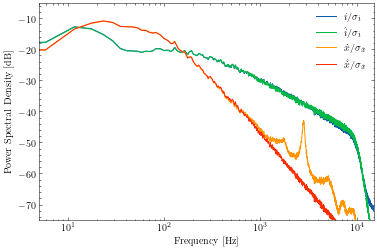

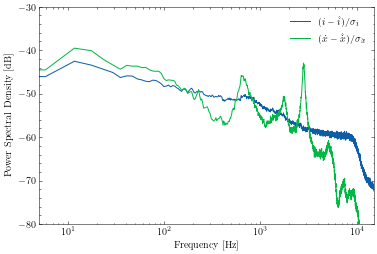

In [26]:
plt.style.use(['science'])

fig, ax = plt.subplots()

f = np.fft.rfftfreq(2**14, d=1/96000)
df_onemodel = df[(df.model == "PolyNonLinSLSL2R2GenCunLi4") & select_highrms_both]

# variances of i, v for each prediction
ivar = df_onemodel.i_psd.apply(np.sum)
vvar = df_onemodel.v_psd.apply(np.sum)

# average over normalized states
i_mean = (df_onemodel.i_psd / ivar).mean()
ipred_mean =(df_onemodel.ipred_psd / ivar).mean()
v_mean = (df_onemodel.v_psd / vvar).mean()
vpred_mean = (df_onemodel.vpred_psd / vvar).mean()

ax.semilogx(f, 10*np.log10(np.abs(i_mean)), label='$i/\sigma_i$')
ax.semilogx(f, 10*np.log10(np.abs(ipred_mean)), label='$\hat i/\sigma_i$')
ax.semilogx(f, 10*np.log10(np.abs(v_mean)), label='$\dot x/\sigma_{\dot x}$')
ax.semilogx(f, 10*np.log10(np.abs(vpred_mean)), label='$\hat {\dot x}/\sigma_{\dot x}$')
ax.set_ylim((-75, -5))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power Spectral Density [dB]')
ax.set_xlim((5, 15000))
ax.legend()

# axins = ax.inset_axes([0.02, 0.02, 0.49, 0.5])
# axins.semilogx(f, 10*np.log10(np.abs(i_mean)), label='$i$')
# axins.semilogx(f, 10*np.log10(np.abs(ipred_mean)), label='$\hat i$')
# axins.semilogx(f, 10*np.log10(np.abs(v_mean)), label='$\dot x$')
# axins.semilogx(f, 10*np.log10(np.abs(vpred_mean)), label='$\dot x$')
# axins.set_xlim((5, 100))
# axins.set_ylim((-10.5,0.5))
# axins.set_xticklabels([])
# axins.set_yticklabels([])

# ax.indicate_inset_zoom(axins)
#plt.savefig('images/comparison_psd.pdf', bbox_inches=None)

fig, ax = plt.subplots()
ierror_mean = (df_onemodel.ei_psd / ivar).mean()
verror_mean = (df_onemodel.ev_psd / vvar).mean()

ax.semilogx(f, 10*np.log10(np.abs(ierror_mean)), label='$(i-\hat i)/\sigma_i$')
ax.semilogx(f, 10*np.log10(np.abs(verror_mean)), label='$(\dot x - \hat {\dot x})/\sigma_{\dot x}$')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power Spectral Density [dB]')
ax.legend()
ax.set_ylim((-80, -30))
ax.set_xlim((5, 15000))

#plt.savefig('images/error_psd.pdf', bbox_inches=None)

# 